In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from torchinfo import summary

import requests
import zipfile
from pathlib import Path

import os

import random
from PIL import Image

from tqdm.auto import tqdm

In [2]:
#Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Sun Feb  5 16:47:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.92.01    Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8     9W /  80W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Reading Data

We will use a sub-data from the Food-101 dataset

In [4]:
#Creating a path/folders for the data
data_path = Path("Data/")
image_path = data_path/"images"

#Creating the folder and adding if to not create folder every time code is run
if image_path.is_dir():
    print("Skipping download")
else:
    print("Creating a directory")
    image_path.mkdir(parents=True, exist_ok=True)

    #Downloading the data
    with open(data_path/"Images_zip.zip", "wb") as file:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading the data")
        file.write(request.content)

    #As the data is in zip file, extract it to image path
    with zipfile.ZipFile(data_path/"Images_zip.zip", "r") as zip_ref:
        print("Extracting")
        zip_ref.extractall(image_path)

Skipping download


In [5]:
#Checking whats in the data

for dirpath, dirname, filename in os.walk(image_path):
    print(f"In {dirpath} there are {len(dirname)} directories and {len(filename)} images")

In Data/images there are 2 directories and 0 images
In Data/images/train there are 3 directories and 0 images
In Data/images/train/pizza there are 0 directories and 78 images
In Data/images/train/steak there are 0 directories and 75 images
In Data/images/train/sushi there are 0 directories and 72 images
In Data/images/test there are 3 directories and 0 images
In Data/images/test/pizza there are 0 directories and 25 images
In Data/images/test/steak there are 0 directories and 19 images
In Data/images/test/sushi there are 0 directories and 31 images


In [6]:
train_path = image_path/"train"
test_path = image_path/"test"

train_path, test_path

(PosixPath('Data/images/train'), PosixPath('Data/images/test'))

pizza


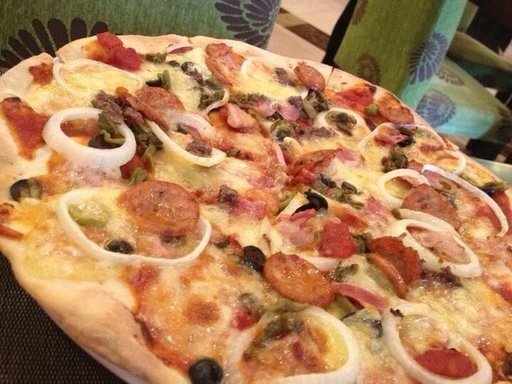

In [7]:
#Visualizing images
images_list = list(image_path.glob("*/*/*.jpg")) #All images from all folders
random_image = random.choice(images_list)
image_label = random_image.parent.stem #Name of its directory is label

img = Image.open(random_image)
print(image_label)
img

#To use matplotlib, convert the image to array using `np.asarray(img)`

### Transorming data

Doing transforms like flipping, cropping is called data augmentation.
> Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set

In [8]:
data_transform = transforms.Compose([
    #Resizing all images
    transforms.Resize(size=(64,64)),
    #Flippling the data to make the model hard to learn
    transforms.RandomHorizontalFlip(p=0.5),
    #Turn to tensor
    transforms.ToTensor()
])

In [9]:
#Making the dataset registerd to pytorch and applying transformations
train_data = datasets.ImageFolder(
    root = train_path,
    transform=data_transform,
    target_transform=None #Not transforming on labels
)

test_data = datasets.ImageFolder(
    root=test_path,
    transform=data_transform
)
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: Data/images/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [10]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [11]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

We can plot the tensors using matplotlib. But the tensor shape is `[color_channels, height, width]` and matplot requires `[height, weight, channels]`. This can be done using `img.permute(1,2,0)`

In [12]:
#Making the data iteratable
BATCH_SIZE = 32
NUM_WROKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WROKERS, #No_of subprocesses to use to load the data
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WROKERS,
    shuffle=False
)

In [13]:
#Will check one image
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### Building Model

In [14]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [15]:
#Try the model on single image
#summary(model_0, input_size=[1,3,64,64])

In [16]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    optimizer: torch.optim.Optimizer,
    device: torch.device = device #Default is gpu if avail
):
    train_acc, train_loss = 0, 0
    model.train() #Not mandatory as default is train
    #Data_Loader outputs X and y in batches
    for batch, (X_train,y_train) in enumerate(data_loader):
        #Use gpu if avail
        X_train, y_train = X_train.to(device), y_train.to(device)
        #Forward
        y_train_pred = model(X_train)
        #Loss
        loss = loss_fn(y_train_pred, y_train)
        train_loss += loss.item()
        #backpropogation
        loss.backward()
        #Optimization
        optimizer.step()
        #Zero out the graidents
        optimizer.zero_grad()
        #Metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y_train).sum().item()/len(y_train_pred)

    train_acc = train_acc / len(data_loader)
    train_loss /= len(data_loader)
    return train_acc, train_loss


In [17]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn,
    device: torch.device = device
):
    test_acc, test_loss = 0, 0
    model.eval()
    with torch.inference_mode(): #Dont track derivates
        for batch, (X_test,y_test) in enumerate(data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            #Forward
            y_test_pred = model(X_test)
            #loss
            loss = loss_fn(y_test_pred, y_test)
            #Metrics
            test_loss += loss.item()
            y_pred_class = y_test_pred.argmax(dim=1)
            test_acc += (y_pred_class == y_test).sum().item()/len(y_pred_class)

        test_acc /= len(data_loader)
        test_loss /= len(data_loader)
        return test_acc, test_loss

Combine `train_step()` and `test_step()`. We will also use `tqdm`, a progress bar.

In [21]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn,
    epochs = 5
):
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [22]:
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

: 

: 